<a href="https://colab.research.google.com/github/imabari/ImabariScraping/blob/master/aichi/aichi_ocr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!add-apt-repository ppa:alex-p/tesseract-ocr -y

!apt update

!apt install tesseract-ocr
!apt install libtesseract-dev

!tesseract -v

!apt install tesseract-ocr-jpn  tesseract-ocr-jpn-vert
!apt install tesseract-ocr-script-jpan tesseract-ocr-script-jpan-vert

!tesseract --list-langs
!pip install pytesseract

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:6 http://ppa.launchpad.net/alex-p/tesseract-ocr/ubuntu bionic InRelease [15.4 kB]
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Get:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release [564 B]
Get:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release.gpg [833 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:12 https://cloud.r-p

In [2]:
import pathlib
import re
from urllib.parse import urljoin

import cv2
import numpy as np
import pytesseract
import requests
from bs4 import BeautifulSoup

In [3]:
# スクレイピング
url = "https://www.pref.aichi.jp/site/covid19-aichi/"

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; WOW64; Trident/7.0; rv:11.0) like Gecko",
}

r = requests.get(url, headers=headers)
r.raise_for_status()

In [4]:
soup = BeautifulSoup(r.content, "html5lib")
src = soup.find("img", alt=re.compile("(検査陽性者|患者発表資料)$")).get("src")

In [5]:
link = urljoin(url, src)
print(link)

# ダウンロード
def get_file(url, dir="."):

    r = requests.get(url)

    p = pathlib.Path(dir, pathlib.PurePath(url).name)
    p.parent.mkdir(parents=True, exist_ok=True)

    with p.open(mode="wb") as fw:
        fw.write(r.content)

    return p

jpg_path = get_file(link)

https://www.pref.aichi.jp/uploaded/image/243379.jpg


In [6]:
from google.colab.patches import cv2_imshow

In [7]:
# 最新ファイル
src = cv2.imread(str(jpg_path))[2:-2, 2:-2]

# ファイルを選択

In [8]:
# 過去用
# src = cv2.imread("2020082918.jpg")[2:-2, 2:-2]

In [9]:
# グレー
gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)

In [10]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
dilated = cv2.dilate(gray, kernel, iterations=1)
diff = cv2.absdiff(dilated, gray)

In [11]:
contour = cv2.bitwise_not(diff)

In [12]:
# JPEGノイズのグレー除去
contour[contour > 180] = 255
# contour[contour < 100] = 0

In [13]:
# リサイズ（横1200固定）
h, w = contour.shape[:2]
wide = int(1200 / w * h)

large = cv2.resize(contour, (1200, wide))

In [14]:
# 楕円形カーネル
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

# モルフォロジー勾配（物体の境界線）
grad = cv2.morphologyEx(large, cv2.MORPH_GRADIENT, kernel)

# 二値化
_, bw = cv2.threshold(grad, 0.0, 255.0, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

# 矩形カーネル
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 1))

# ノイズ除去
connected = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel)

# cv2.RETR_EXTERNAL 輪郭
# cv2.CHAIN_APPROX_NONE 輪郭全点の情報を保持

contours, hierarchy = cv2.findContours(
    connected.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE
)

mask = np.zeros(bw.shape, dtype=np.uint8)

rects = []

for idx in range(len(contours)):
    # 外接矩形
    x, y, w, h = cv2.boundingRect(contours[idx])

    mask[y : y + h, x : x + w] = 0

    # 輪郭を描画
    cv2.drawContours(mask, contours, idx, (255, 255, 255), -1)

    # 面積割合
    r = float(cv2.countNonZero(mask[y : y + h, x : x + w])) / (w * h)

    # 面積、縦・横長さ（表のみ抽出）
    if r > 0.45 and w > 850 and h > 100:
        rects.append((x, x + w, y, y + h))

# Y下、X左でソート
rects = sorted(rects, key=lambda x: (x[3], x[0]))

# 個数
print(len(rects))

3


In [15]:
print(rects)

[(21, 1163, 94, 261), (126, 1163, 337, 504), (21, 1163, 713, 1304)]


In [16]:
# 表１座標
x1, x2, y1, y2 = rects[0]

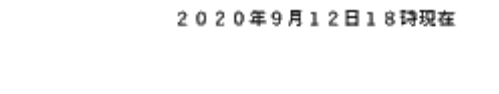

In [17]:
# 日付用
dst = large[0:y1, 700:-1].copy()
cv2_imshow(dst)

In [18]:
txt = (
    pytesseract.image_to_string(dst, lang="jpn", config="--psm 6")
    .strip()
    .replace(".", "")
    .replace(",", "")
    .replace(" ", "")
)
print(txt)

2020年9月12日18対現在


In [19]:
import datetime

In [20]:
y, m, d, h = map(int, re.findall("\d+", txt))

In [21]:
dt_now = datetime.datetime(y, m, d, h)

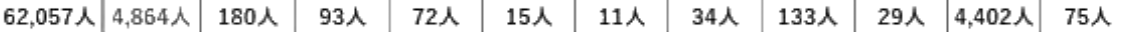

In [22]:
y_crop = int((y2 - y1) * 0.23)

# 切り出し
dst = large[y1:y2, x1:x2][-y_crop:-6, 5:-5].copy()

cv2_imshow(dst)

In [23]:
edges = cv2.Canny(dst, 100, 200, apertureSize=3)
lines = cv2.HoughLines(edges, 1, np.pi / 2, 25)

# 縦線削除
# theta 角度
for line in lines:
    for rho, theta in line:

        if theta == 0:

            a = np.cos(theta)
            # b = np.sin(theta)

            x0 = int(a * rho)

            x1, x2 = x0, x0
            y1, y2 = 100, -100

            cv2.line(dst, (x1, y1), (x2, y2), (255, 255, 255), 5)

In [24]:
def data_check(text):
    print(text)

    data = list(map(int, re.findall("\d+", text)))
    print(data)

    if(len(data) == 12):
        if data[2] == data[3] + data[4] + data[5]:
            if data[1] == data[2] + data[6] + data[7] + data[8] + data[9] + data[10] + data[11]:
                return data
            else:
                print("陽性者数の集計があいません")
        else:
            print("入院の集計があいません")
    else:
        print("データ数が足りません")

    return None

In [25]:
txt = (
    pytesseract.image_to_string(dst, lang="jpn", config="--psm 6")
    .strip()
    .replace(".", "")
    .replace(",", "")
)
data = data_check(txt)

62057人 4864人 180人 。 93人 72人  15人  11人 。 34人 133人 29人 4402人人 75人
[62057, 4864, 180, 93, 72, 15, 11, 34, 133, 29, 4402, 75]


In [26]:
txt = (
    pytesseract.image_to_string(dst, lang="jpn", config="--psm 3")
    .strip()
    .replace(".", "")
    .replace(",", "")
)
data = data_check(txt)

62057人 4864人 180人 。 93人 72人  15人  11人 。 34人 133人 29人 4402人人 75人
[62057, 4864, 180, 93, 72, 15, 11, 34, 133, 29, 4402, 75]


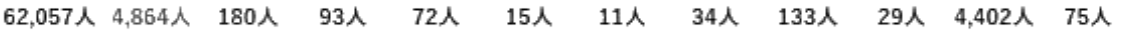

In [27]:
cv2_imshow(dst)

In [28]:
cv2.imwrite("main.png", dst)

True

In [29]:
txt = (
    pytesseract.image_to_string(dst, lang="jpn", config="--psm 11")
    .strip()
    .replace(".", "")
    .replace(",", "")
)
data_check(txt)

62057人 4864人

180人

93人

72人

15人

11人

34人

133人

29人 4402人人 。 75人
[62057, 4864, 180, 93, 72, 15, 11, 34, 133, 29, 4402, 75]


[62057, 4864, 180, 93, 72, 15, 11, 34, 133, 29, 4402, 75]

In [30]:
cv2.imwrite("main.png", dst)

True

In [31]:
# 表２座標
x1, x2, y1, y2 = rects[1]

# 表３座標
x3, x4, y3, y4 = rects[2]

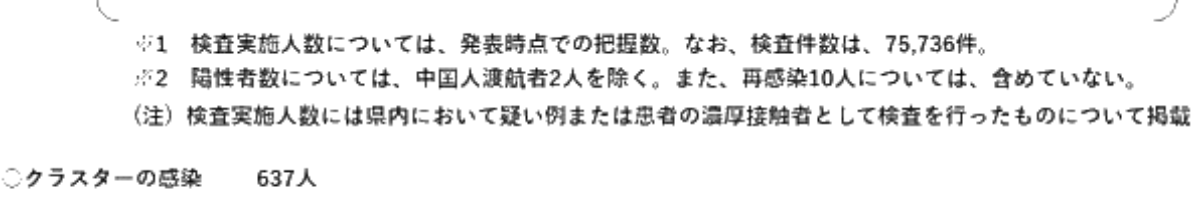

In [32]:
dst = large[y2:y3, 0:-1].copy()
cv2_imshow(dst)

In [33]:
txt = (
    pytesseract.image_to_string(dst, lang="jpn", config="--psm 6")
    .strip()
    .replace(".", "")
    .replace(",", "")
    .replace(" ", "")
)
print(txt)

1検査実施人数については、発表時点での把握数。なお、検査件数は、75736件。
証2性者数については、中国人渡航者2人を除く。また、再感染10人については、含めていない。
(注)検査実施人迷には県内において疑い例または悪者の温厚接触者として検査を行ったものについて掲載
ークラスターの三共。637人


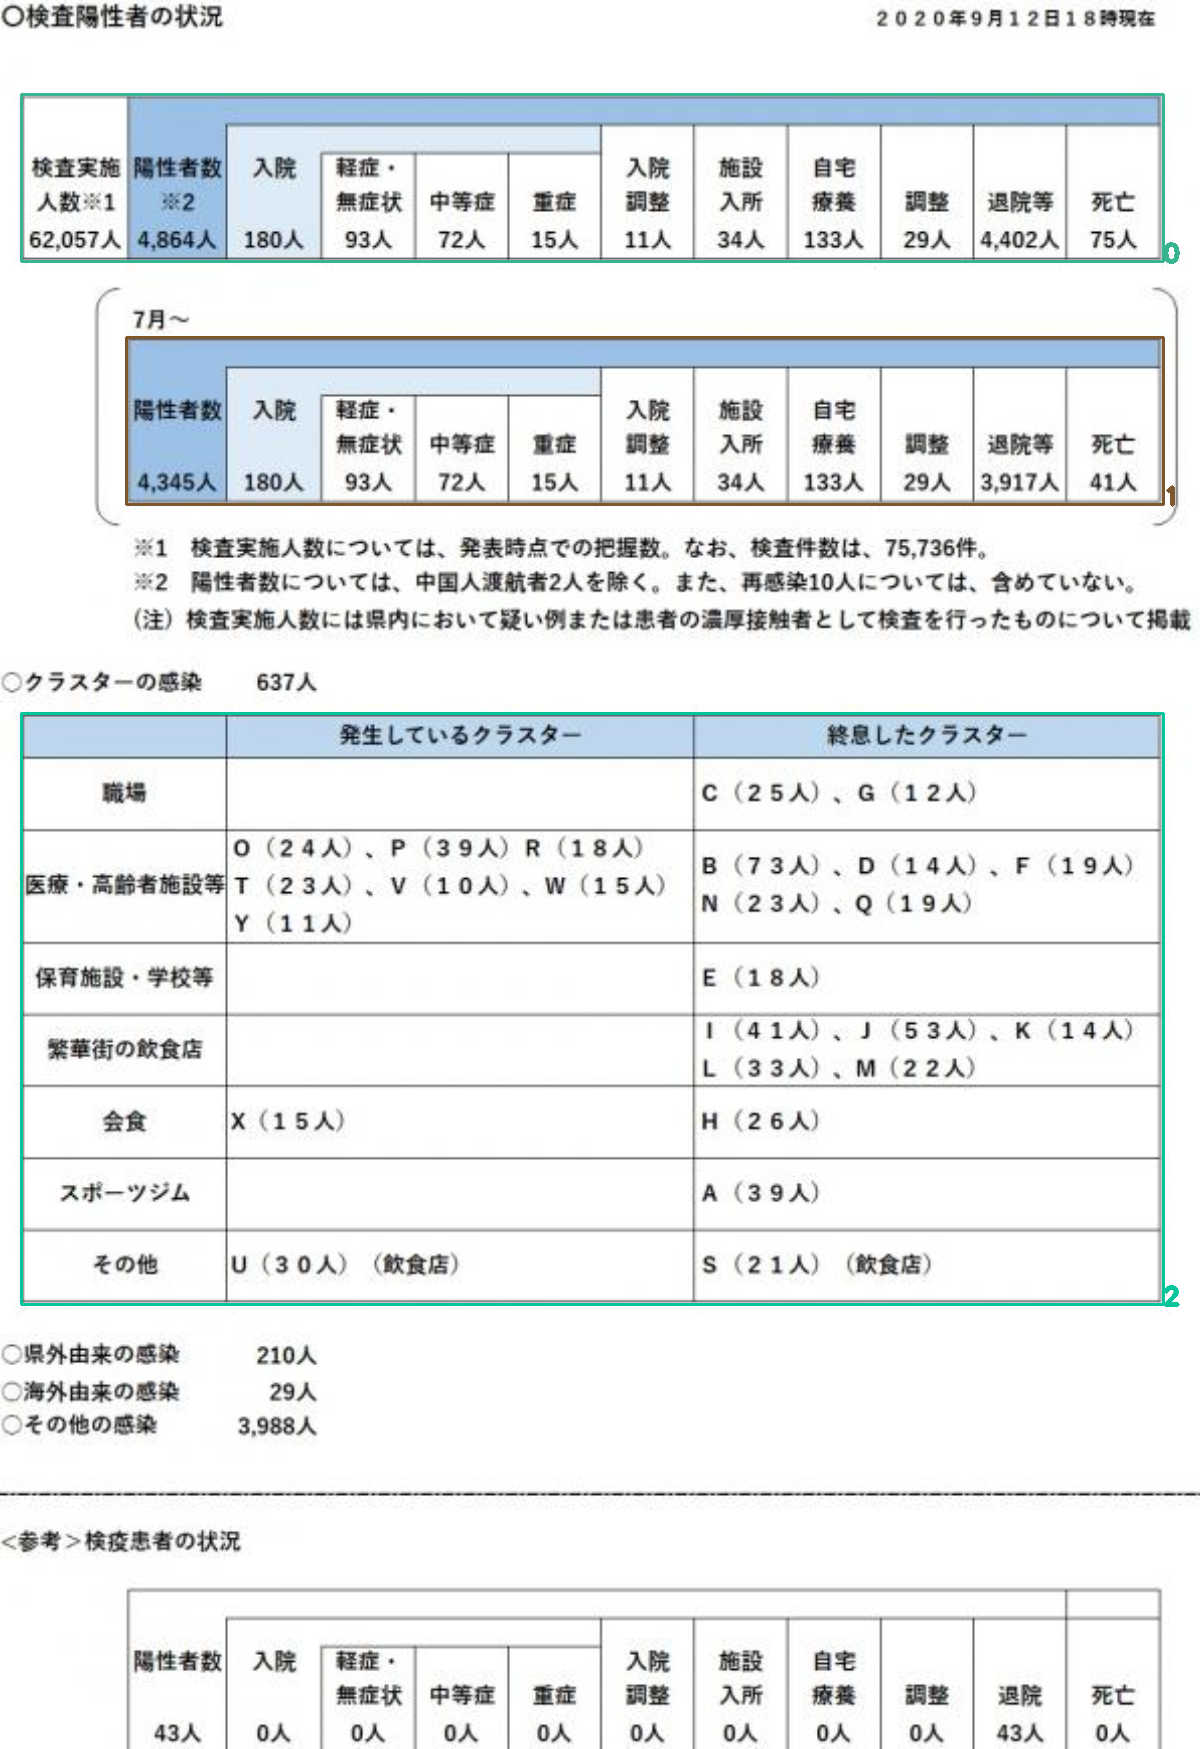

In [34]:
img = cv2.resize(src, (1200, wide))

for idx, rect in enumerate(rects):

    x1, x2, y1, y2 = rect

    color = np.random.randint(0, 255, 3).tolist()
    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
    cv2.putText(img, str(idx), (x2, y2), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 3)
    
cv2_imshow(img)